Final notes / improvements after doing the analysis:
- improve working with unstructured data in pandas dataframe
- work on big data files => spacy
- comment tester au fur et à mesure les résultats du notebook ? 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator


%matplotlib inline

# Avito 

info 
- 3 diff types of ads available to sellers on Avito: regular, highlighted, and context. 
- context ads : predict which ad will be the most relevant for (and earn the most clicks from) each potential buyer. 
- **improve on their model by predicting if individual users will click a given context ad.**
- i.e. more accurately predict click-through rates for their ads

f(x) ~ y where y is "isClick" meaning does the person has clicked on the ad  
R -> {0,1} => binary classif


## Intro

### Dataset

Click through rate = (#click / #impression ) * 100

PHONEREQUESTS: 
IPID - anonymized identifier of visitor's IP. => is it different from UserID ? 





### Conjecture

Qu'est-ce qui fait qu'on clique sur une ad de context ?  
On clique si l'ad est personnalisée, si elle est adaptée à ce que je recherche ou ce que je suis.  
Ex : pub pour des couches pour une femme enceinte.  
Comment le match entre l'attente de l'utilisateur et le contenu se fait ? L'ad doit être en lien avec les caractéristiques de l'utilsateur. Elle doit probablement être proche de l'intitulé de la recherche ou des filtres mis en place pdt la recherche.  


Un autre facteur dans la décision probable, c'est le profil de l'utilisateur. Certains clique volontier sur des offres de context, d'autres non.  

Le type de la pub joue intrinsèquement un rôle. Ex une pub pour smartphone est + populaire qu'une pub pour un fer à cheval. 

isClick ~ HistCTR + ... + AdsInfo.price + 


### Analyse
=> analyser les recherches 
    quelles recherches sont les + populaires ? 
    ça implique p-e de traduire les queries

=> analyser les ads  
    quelles ads sont les + populaires  
        + d'impression  
        + de clicks
Il doit y avoir une forte correlation entre la top add de la recherche et l'ad context 
    
=> analyser les users  
    quels utilisateurs font le + de recherche ?  
    est-ce qu'on peut dresser des profils d'utilisateurs ? En fonction de leurs envie ?
    est-ce que certaines zones ont des profils d'utilisateurs avec des envies spécifiques ? 
 
    
Traduire : query dans SearchInfos + les categories


In [3]:
ROOT_DIR = '/mnt/f/avito-kaggle/'
SAMPLE_SIZE = 1e4

In [4]:
search_info = pd.read_csv(f"{ROOT_DIR}SearchInfo.tsv", nrows=SAMPLE_SIZE, delimiter="\t", encoding="utf-8-sig"
)

In [5]:
! ls /mnt/f/avito-kaggle

7zfiles       PhoneRequestsStream.tsv  avito-context-ad-clicks.zip
AdsInfo.tsv   SearchInfo.tsv	       testSearchStream.tsv
Category.tsv  UserInfo.tsv	       trainSearchStream.tsv
Location.tsv  VisitsStream.tsv


In [6]:
location = pd.read_csv(f'{ROOT_DIR}location.tsv', sep='\t')
user_info = pd.read_csv(f'{ROOT_DIR}userInfo.tsv', sep='\t')
category = pd.read_csv(f'{ROOT_DIR}category.tsv', sep='\t')

In [7]:
ads_info = pd.read_csv(f'{ROOT_DIR}AdsInfo.tsv', sep='\t', nrows=SAMPLE_SIZE)

In [8]:
visits_stream = pd.read_csv(f'{ROOT_DIR}VisitsStream.tsv', sep='\t', nrows=SAMPLE_SIZE)

In [9]:
phone_requests_stream = pd.read_csv(f'{ROOT_DIR}PhoneRequestsStream.tsv', sep='\t')

In [10]:
train_search_stream = pd.read_csv(f'{ROOT_DIR}trainSearchStream.tsv', sep='\t', nrows=SAMPLE_SIZE)
test_search_stream = pd.read_csv(f'{ROOT_DIR}testSearchStream.tsv', sep='\t', nrows=SAMPLE_SIZE)

## Data analysis

### Missing values

In [11]:
def show_missing_values(df):
    print(df.name)
    print(df.isna().sum())
    print(f'Total missing values: {df.isna().sum().sum()}\n')

In [12]:
# 8 tables => 9 df (search stream df divided train/test)
search_info.name = "search_info" #échantillonné
location.name = "location"
user_info.name = "user_info"
category.name = "category"
ads_info.name = "ads_info" #échantillonné
visits_stream.name = "visits_stream" #échantillonné
phone_requests_stream.name = "phone_requests_stream" 
train_search_stream.name = "train_search_stream" #échantillonné
test_search_stream.name = "test_search_stream" #échantillonné

dfs = dict(
    search_info = search_info,
    location = location, 
    user_info = user_info, 
    category = category, 
    ads_info = ads_info,
    visits_stream = visits_stream, 
    phone_requests_stream = phone_requests_stream, 
    train_search_stream = train_search_stream, 
    test_search_stream = test_search_stream
)

In [13]:
for df in dfs.values():
    show_missing_values(df)

search_info
SearchID             0
SearchDate           0
IPID                 0
UserID               0
IsUserLoggedOn       0
SearchQuery       8438
LocationID           0
CategoryID           0
SearchParams      5128
dtype: int64
Total missing values: 13566

location
LocationID    0
Level         0
RegionID      1
CityID        1
dtype: int64
Total missing values: 2

user_info
UserID               0
UserAgentID          0
UserAgentOSID        0
UserDeviceID         0
UserAgentFamilyID    0
dtype: int64
Total missing values: 0

category
CategoryID          0
Level               0
ParentCategoryID    0
SubcategoryID       0
dtype: int64
Total missing values: 0

ads_info
AdID            0
LocationID     12
CategoryID      0
Params        261
Price           0
Title           0
IsContext       0
dtype: int64
Total missing values: 273

visits_stream
UserID      0
IPID        0
AdID        0
ViewDate    0
dtype: int64
Total missing values: 0

phone_requests_stream
UserID              0
IPI

SEARCH INFO :  
Pas de surprise pour ce dataframe les variables searchquery et searchparams présentent des valeurs manquantes. Le reste non  
Pour rappel :  
- SearchParams dictionary-like structure with optional filters of the search if they were specified while search. NULL otherwise.
- SearchQuery - raw query text if it was specified while search. NULL otherwise.

LOCATION :
2 NA sur une seule ligne

In [14]:
location[location.isna().any(axis=1)] #bizarrement pour cette ligne on a pas de regionID ni de CityID. Pour l'instant je la laisse

,LocationID,Level,RegionID,CityID
2483,2885,1,NaN,NaN


ADS INFO (échantillonné) :  
LocationID présente des valeurs manquante (peu). En revanche sans surprise Params présente de nombreuses valeurs manquantes.  
Pour rappel : Params parameters for the context ad in dictionary-like format. NULL for some ads (where no parameters are available). Ex : gender, size , ...  
Note that both Params from AdsInfo.tsv and SearchParams from SearchInfo.tsv shares same dictionary (keys and values).
=> pas de modifs

TRAIN & TEST SEARCH :
Only HistCTR qui présente des valeurs manquantes. Parait normal aussi => pas de modifs

### Distribution de la variable cible - isClick

Essayons de voir si on ne peut pas la charger en entier sans faire planter la RAM

In [15]:
#y = pd.read_csv(f'{ROOT_DIR}trainSearchStream.tsv', sep='\t', usecols=["IsClick"], squeeze=True)

In [16]:
def plot_binary_distribution(y):
    # Count the number of occurrences of each class in y
    class_counts = y.value_counts()

    # Get the names of the classes
    class_names = class_counts.index

    # Set the figure size
    plt.figure(figsize=(5,5))

    # Create a pie chart to display the distribution of the classes
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', shadow=True, startangle=90)

    # Add a title
    plt.title('Distribution of IsClick Variable')

    # Display the plot
    plt.show()

In [17]:
#plot_binary_distribution(y)

Jeux de données déséquilibré : => utilisation de métrics spécifiques pour la prédiction. On ne peut pas utiliser l'accuracy ni courbe ROC. On va privilégier le score F1 & courbe Precision / Recall

Idée - tout réunir dans une table et évaluer les corrélation avec la variable cible. Pb on a pas de valeurs 1 sur l'échantillons. Impossible de loader un échantillon stratifié 
 

 ### Analyse sur échantillon 

 Pour rappel ce qu'on veut faire : 

=> analyser les recherches 
    quelles recherches sont les + populaires ? 
    ça implique p-e de traduire les queries

=> analyser les ads  
    quelles ads sont les + populaires  
        + d'impression  
        + de clicks
Il doit y avoir une forte correlation entre la top add de la recherche et l'ad context 
    
=> analyser les users  
    quels utilisateurs font le + de recherche ?  
    est-ce qu'on peut dresser des profils d'utilisateurs ? En fonction de leurs envie ?
    est-ce que certaines zones ont des profils d'utilisateurs avec des envies spécifiques ? 
 
    
Traduire : query dans SearchInfos + les categories

Traduction des paramètres de recherche (SearchParams):

In [18]:
import json
tmp = search_info['SearchParams'].drop_duplicates().values
s = pd.Series(tmp, dtype=str)\
    .str.replace('\'', '\"')\
    .str.replace(r'({|, )(\d*)', lambda m: m.group(1) + "\"" + m.group(2) + "\"" if m.group(2) else m.group(1))
ru_dic_search_params = {}
error = []
for i, ss in enumerate(s[1:]): #get rid of NA
    try: 
        ru_dic_search_params.update(json.loads(ss))
    except:
        error.append(ss)

/tmp/ipykernel_18663/2247959857.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  s = pd.Series(tmp, dtype=str)\


In [19]:
error

['{"797":"15", "796":"Штампованные", "709":"Диски", "799":"5", "5":"Шины, диски и колёса", "801":{from:"-40"}, "800":"139.7"}',
 '{"797":"16", "796":"Литые", "709":"Диски", "799":"5", "798":"6.5", "5":"Шины, диски и колёса", "801":{to:"50"}, "800":"112"}',
 '{"797":"16", "709":"Диски", "799":"6", "798":"7", "5":"Шины, диски и колёса", "801":{to:"-15", from:"-15"}, "800":"139.7"}',
 '{"797":"22", "709":"Диски", "799":"5", "798":"9.5", "5":"Шины, диски и колёса", "801":{to:"35"}, "800":"114.3"}',
 '{"797":"16", "709":"Диски", "799":"5", "5":"Шины, диски и колёса", "801":{to:"45", from:"37"}, "800":"114.3"}',
 '{"797":"15", "796":"Литые", "709":"Диски", "799":"6", "798":"7", "5":"Шины, диски и колёса", "801":{from:"-10"}, "800":"139.7"}']

Toutes ces erreurs sont déjà dans le dict. On va pouvoir le traduire : 

In [20]:
tr = Translator()
fr_dic_search_params = {}
for ru_key, ru_value in ru_dic_search_params.items():
    fr_dic_search_params[ru_key] = tr.translate(ru_value, src='ru', dest='fr').text

In [21]:
tmp = search_info['SearchParams'].dropna().reset_index(drop=True)

In [22]:
s = pd.Series(search_info['SearchParams'], dtype=str)\
    .str.replace('\'', '\"')\
    .str.replace(r'({|, )(\d*)', lambda m: m.group(1) + "\"" + m.group(2) + "\"" if m.group(2) else m.group(1))

/tmp/ipykernel_18663/293331707.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  s = pd.Series(search_info['SearchParams'], dtype=str)\


In [23]:
s_result = pd.Series([np.nan]*len(s))
for i, ss in enumerate(s):
    try:
        tmp = json.loads(ss)
        dic = {}
        for key in tmp.keys():
            dic[key] = fr_dic_search_params[key]
        s_result[i] = str(dic)
    except:
        pass

In [24]:
search_info['frSearchParams'] = s_result

Translating SearchQuery

In [25]:
# As this line text 6 minutes to run, we will simply load the saved serie 
# # (in case we need to restart the kernel)
#tmp = search_info['SearchQuery'].dropna().apply(lambda s: tr.translate(s, dest='fr').text)
# search_info['frSearchQuery'] = pd.Series([np.nan]*search_info.shape[0])
# search_info['frSearchQuery'][tmp.index] = tmp
##substitut
search_info['frSearchQuery'] = pd.read_csv('saved_data/frSearchQuery.csv', squeeze=True, index_col=0)

In [26]:
# on trad aussi en anglais vu que les algo de NER ont plus de labels dans ce langage
#tmp = search_info['SearchQuery'].dropna().apply(lambda s: tr.translate(s, dest='en').text)
search_info['enSearchQuery'] = pd.read_csv('saved_data/enSearchQuery.csv', squeeze=True, index_col=0)

In [27]:
# search_info['enSearchQuery'] = pd.Series([np.nan]*search_info.shape[0])
# search_info['enSearchQuery'][tmp.index] = tmp

Traduction terminée, on va pouvoir voir quelles sont les recherches les plus populaires et ainsi que les paramètres les plus populaires  

**Recherches les + populaires**

In [28]:
print(f'Il y a {search_info["frSearchQuery"].isna().sum()} valeurs manquantes\
    ce qui représente {search_info["frSearchQuery"].isna().sum()/len(search_info)*100} %')
search_info['frSearchQuery'].value_counts()[:20] #20 recherches les plus prisées

Il y a 8438 valeurs manquantes    ce qui représente 84.38 %


vélo                 42
canapé               25
poussette            22
sac                  20
poussettes           20
des chaussures       18
baskets              17
Ceci est un vélo     14
des sandales         13
table                12
robe                 12
réfrigérateur        12
uaz                   9
vases                 9
sur le vase           9
trottinette           8
iphone 6              8
iphone                8
je donnerai           8
vélo pour enfants     8
Name: frSearchQuery, dtype: int64

In [29]:
search_info['frSearchQuery'].drop_duplicates().dropna().to_csv("queries.txt")

Question : comment regrouper certaines query dans des catégories plus importantes pour faire émerger de l'information ? Ex : "vélo", "vélo", "vélo électrique", "BMX" ?

==> NLP : name entity recognition ? Spacy ?

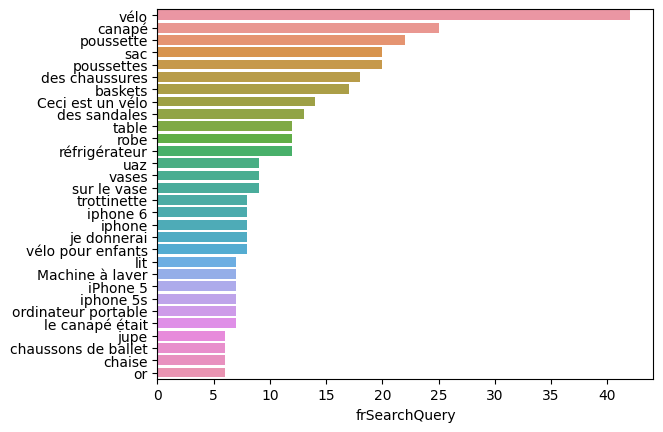

In [30]:
tmp = search_info['frSearchQuery'].value_counts()[:30]
sns.barplot(x=tmp, y = tmp.index) ; 

Ex : on voit bien que "vélo pour enfants" et "vélo" par exemple concernent la même recherche "vélo"

NER  
https://spacy.io/usage/linguistic-features  => Named entity recognition 101

A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction


In [31]:
#! python -m spacy download fr_core_news_sm

In [32]:
import spacy

##French pipeline
# nlp= spacy.load("fr_core_news_sm")
# def show_entities(s):
#     doc = nlp(s)
#     for ent in doc.ents:
#         print(ent.text, ent.start_char, ent.end_char, ent.label_)


#en pipeline 
nlp = spacy.load('en_core_web_sm')

In [33]:
for i in ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", 
"LANGUAGE", "LAW", "LOC", "MONEY", "NORP", "ORDINAL", "ORG", 
"PERCENT", "PERSON", "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]:
    print(i, spacy.explain(i))

CARDINAL Numerals that do not fall under another type
DATE Absolute or relative dates or periods
EVENT Named hurricanes, battles, wars, sports events, etc.
FAC Buildings, airports, highways, bridges, etc.
GPE Countries, cities, states
LANGUAGE Any named language
LAW Named documents made into laws.
LOC Non-GPE locations, mountain ranges, bodies of water
MONEY Monetary values, including unit
NORP Nationalities or religious or political groups
ORDINAL "first", "second", etc.
ORG Companies, agencies, institutions, etc.
PERCENT Percentage, including "%"
PERSON People, including fictional
PRODUCT Objects, vehicles, foods, etc. (not services)
QUANTITY Measurements, as of weight or distance
TIME Times smaller than a day
WORK_OF_ART Titles of books, songs, etc.


In [34]:
search_info['enSearchQuery'].dropna().value_counts()[:10]

bicycle              42
sofa                 25
stroller             22
bag                  20
shoes                18
sneakers             17
baby carriages       15
This is a bicycle    14
sandals              13
dress                12
Name: enSearchQuery, dtype: int64

In [35]:
#spacy good practises
# BAD : docs = [nlp(text) for text in LOTS_OF_TEXTS]
# GOOD : docs = list(nlp.pipe(LOTS_OF_TEXTS))
tmp = search_info['enSearchQuery'].dropna()
data = [(value, context) for value, context in zip(tmp.values, tmp.index)]
result = []
for doc, context in nlp.pipe(data, as_tuples=True):
    tmp = {'query': doc.text, 'ents':[[ent.text, ent.start_char, ent.end_char, ent.label_] for ent in doc.ents]}
    result.append([doc.text] + [[ent.text, ent.start_char, ent.end_char, ent.label_] for ent in doc.ents])
    if len(tmp['ents']) > 1:
        print(tmp)

{'query': 'Chevrolet Cruze', 'ents': [['Chevrolet', 0, 9, 'ORG'], ['Cruze', 10, 15, 'PRODUCT']]}
{'query': 'ford focus 1', 'ents': [['ford', 0, 4, 'ORG'], ['1', 11, 12, 'CARDINAL']]}
{'query': 'sony xperia', 'ents': [['sony', 0, 4, 'ORG'], ['xperia', 5, 11, 'GPE']]}
{'query': 'ford focus 2', 'ents': [['ford', 0, 4, 'ORG'], ['2', 11, 12, 'CARDINAL']]}
{'query': 'ford focus 2', 'ents': [['ford', 0, 4, 'ORG'], ['2', 11, 12, 'CARDINAL']]}
{'query': 'Chevrolet Lacetti', 'ents': [['Chevrolet', 0, 9, 'ORG'], ['Lacetti', 10, 17, 'PRODUCT']]}
{'query': 'Chevrolet Cruze', 'ents': [['Chevrolet', 0, 9, 'ORG'], ['Cruze', 10, 15, 'PRODUCT']]}
{'query': 'toyota rav 4', 'ents': [['toyota', 0, 6, 'ORG'], ['4', 11, 12, 'CARDINAL']]}
{'query': 'Chevrolet Cruze', 'ents': [['Chevrolet', 0, 9, 'ORG'], ['Cruze', 10, 15, 'PRODUCT']]}
{'query': 'apple iphone 5s 32gb', 'ents': [['5s', 13, 15, 'CARDINAL'], ['32', 16, 18, 'CARDINAL']]}
{'query': 'honda cr v', 'ents': [['honda', 0, 5, 'ORG'], ['cr v', 6, 10, 'PERS

We see that in this particular case Spacy isn't working properly at recognizing entities ...

In [36]:
l = []
for doc, context in nlp.pipe(data, as_tuples=True):
    l.append([ent.label_ for ent in doc.ents])
s = pd.Series([x for sublist in l for x in sublist])
s.value_counts()

ORG         172
CARDINAL    103
PERSON       57
PRODUCT      18
GPE          17
DATE         10
TIME          4
NORP          1
MONEY         1
FAC           1
dtype: int64

Pas très pertinent sachant qu'à mon avis on a quasiment aucun nom propre dans les recherches

**Paramètres les plus populaires** 

On vuet pouvoir avoir un dictionnaire plutot qu'une chaine de caractères pour chaque ligne. 
=> json.loads mais il faut remplacer les ' par les "  
Attention pas tous ex :  
{"175": 'Vêtements pour femmes'} #normal  
{'45': "Objets d'intérieur, art"} #apostrophe dans le text  
{'487': 'fers', '48': 'Autre'} #ici les valeurs ne sont pas entre ""

In [148]:
def search_params_to_dict(col):
    """
    Transform a pd.Series of unstrustured strings into a list of dict
    """
    tmp = col.dropna()
    strings_of_params = tmp.str.replace(r'(?<={)\'', '\"', regex=True)\
        .str.replace(r'\'(?=})', '\"', regex=True) \
        .str.replace(r'\'(?=\:)', '\"', regex=True)\
        .str.replace(r'(?<=\,\s)\'', '\"', regex=True) \
        .str.replace(r'(?<=:\s)\'', '\"', regex=True) \
        .str.replace(r'\'(?=,)', '\"', regex=True)
    list_dicts_params = []
    for string in strings_of_params:
        list_dicts_params.append(json.loads(string))
    return list_dicts_params

list_dicts_params = search_params_to_dict(search_info['frSearchParams'])

In [145]:
#count the most frequent categories 
from collections import defaultdict

params_count = defaultdict(int)

for dic in list_dicts_params:
    for v in dic.values():
        params_count[v] += 1

df = pd.DataFrame(params_count.items(), columns=['nameOfParam', 'count']).sort_values(by='count', ascending=False)

<AxesSubplot:xlabel='count', ylabel='nameOfParam'>

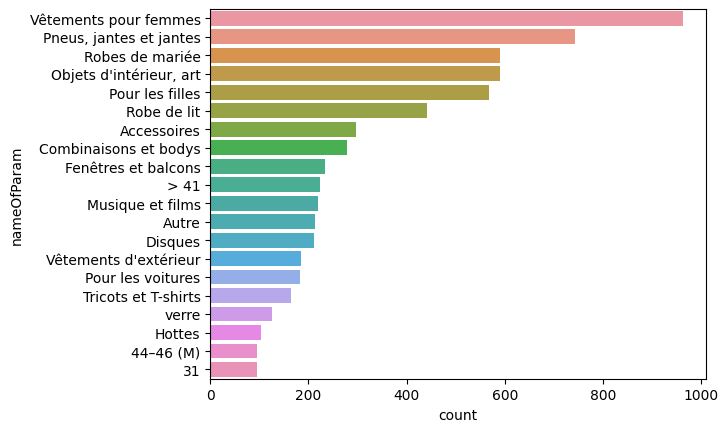

In [146]:
sns.barplot(x='count',y='nameOfParam', data=df[:20])

Sur cet échantillon les catégories les plus recherchées sont donc les vêtements pour femmes, les pneus jantes etc, et les robes de mariée.

=> les ads en lien avec une de ces catégories doit fortement augmenter la probabilité que la personne clique sur une ad de manière absolue. Après c'est pas spécifique, si l'on propose des vêtements pour femmes à un homme ça réduit largement la proba. Anyway, la variable Params doit avoir un fort lien avec la variable cible (2 var qualitative => pour tester on pourrait faire un test du chi2)

#### Analyser les ads

=> analyser les ads  
    quelles ads sont les + populaires  
        + d'impression  
        + de clicks
Il doit y avoir une forte correlation entre la top add de la recherche et l'ad context 

/home/francois/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IsClick', ylabel='HistCTR'>

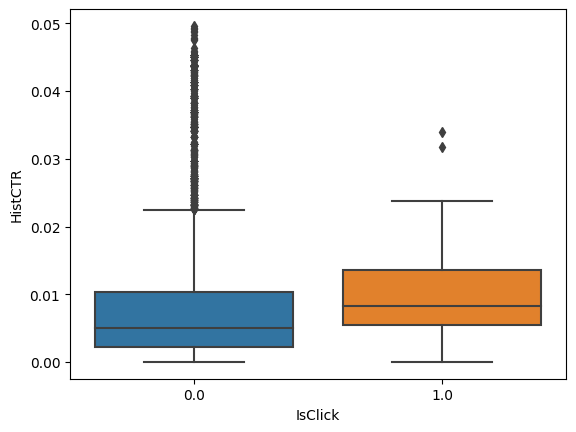

In [41]:
sns.boxplot('IsClick', y='HistCTR', data=train_search_stream.loc[train_search_stream.HistCTR < 0.05, :])

Il y a donc une différence. Mais est-elle significative ? Différence de moyenne entre 2 groupes => test de student ! 

In [42]:
# il y a donc une 

tmp0 = train_search_stream.loc[train_search_stream.IsClick == 0]
tmp1 = train_search_stream.loc[train_search_stream.IsClick == 1]

In [43]:
# on dirait qu'il y a des outliers
train_search_stream.loc[train_search_stream.HistCTR > 0.1, ]

,SearchID,AdID,Position,ObjectType,HistCTR,IsClick
1960,568,5866465,1,3,0.100213,0.0
2011,582,22602336,1,3,0.114568,0.0
2330,679,33353737,1,3,0.123796,0.0
4001,1183,34154066,1,3,0.207862,0.0
5547,1632,25972884,1,3,0.231168,1.0
6750,1978,36722591,1,3,0.111687,0.0
7221,2117,2757837,1,3,0.135928,0.0
7231,2120,34154066,1,3,0.207862,0.0
7698,2256,4104382,1,3,0.129411,0.0
8694,2556,13666723,1,3,0.135928,0.0


Ca pourrait être intéressant de voir quels sont ces outliers ? Ca implique d'avoir l'ads correspondant cependant ça coince vu qu'on a pas ads en entier => (spark ?)



Suite de l'analyse : 

=> analyser les users  
    quels utilisateurs font le + de recherche ?  
    est-ce qu'on peut dresser des profils d'utilisateurs ? En fonction de leurs envie ?
    est-ce que certaines zones ont des profils d'utilisateurs avec des envies spécifiques ? 


In [44]:
user_info

,UserID,UserAgentID,UserAgentOSID,UserDeviceID,UserAgentFamilyID
0,1,44073,30,2019,9
1,2,12505,20,2014,85
2,3,24256,20,2014,64
3,4,57133,20,2014,25
4,5,57133,20,2014,25
...,...,...,...,...,...
4284818,4339857,7075,20,2014,62
4284819,4339858,1393,30,2019,9
4284820,4339859,57133,20,2014,25
4284821,4339860,63091,20,2014,25


Est-ce que le navigateur ou le type de device a une influence sur le fait que la personne clique ? Possible au final. A un browser correspond un affichage spécifique. Si l'affichage des ads est très mauvais ça peut empêcher la personne de cliquer. Mais bon pas hyper probable

KPI de récurrence pour un user : 
- #click per user (isClick)
- #search per user (merge Userinfo et Searchinfo, count distinct searchID per user)
- #visits per user (merge userinfo et VisitsStream, count distinct visit per user)

KPI de genre de user (a-t-il tendance à cliquer sur les ads de context) :
- #Isclick/ #impressions (#impressions = #ads per seach x #search of a user)
- #Isclick / #search


Type d'envie de l'user :
- Investigate the research params for the search of a specific user

In [149]:
#let's try to understand the favorite categories of a user

In [184]:
tmp = pd.merge(user_info, search_info, how='inner')[['UserID', 'SearchID', 'frSearchParams']] 

In [185]:
tmp

,UserID,SearchID,frSearchParams
0,977,5057,NaN
1,1301,5043,NaN
2,3166,8920,"{'179': 'Combinaisons et bodys', '178': 'Pour ..."
3,3265,9836,NaN
4,3403,1601,NaN
...,...,...,...
9993,4337804,3336,"{'45': ""Objets d'intérieur, art""}"
9994,4338038,4870,NaN
9995,4338213,883,NaN
9996,4338426,6221,{'127': 'Robe de lit'}


In [186]:
user_ids = (tmp.groupby('UserID').agg(nb_search = ('SearchID', 'count')) > 1).index
mask = (tmp.groupby('UserID').agg(nb_search = ('SearchID', 'count')) > 1).nb_search.values

## Using Pyspark

Let's try to load the data using Pyspark
4 datasets échantillonnés : 
- adsinfo
- visits streams
- train_search_info
- test_search_info

In [187]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [188]:
sc = SparkContext()
spark = SparkSession(sc)

your 131072x1 screen size is bogus. expect trouble


22/12/26 10:20:44 WARN Utils: Your hostname, BIOS-D4858G3 resolves to a loopback address: 127.0.1.1; using 192.168.221.174 instead (on interface eth0)
22/12/26 10:20:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/26 10:20:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [189]:
! spark-submit --version

22/12/26 10:23:49 WARN Utils: Your hostname, BIOS-D4858G3 resolves to a loopback address: 127.0.1.1; using 192.168.221.174 instead (on interface eth0)
22/12/26 10:23:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/
                        
Using Scala version 2.12.15, OpenJDK 64-Bit Server VM, 1.8.0_342
Branch HEAD
Compiled by user yumwang on 2022-10-15T09:47:01Z
Revision fbbcf9434ac070dd4ced4fb9efe32899c6db12a9
Url https://github.com/apache/spark
Type --help for more information.


In [191]:
spark.version

'3.3.1'

In [192]:
# étude de la variable cible
ROOT_DIR = '/mnt/f/avito-kaggle'
df = spark.read.csv(f"{ROOT_DIR}/trainSearchStream.tsv", header=True, inferSchema=False, sep='\t')

In [193]:
df.columns

['SearchID', 'AdID', 'Position', 'ObjectType', 'HistCTR', 'IsClick']

In [195]:
df.count()

392356948

In [196]:
df.head(5)

[Row(SearchID='2', AdID='11441863', Position='1', ObjectType='3', HistCTR='0.001804', IsClick='0'),
 Row(SearchID='2', AdID='22968355', Position='7', ObjectType='3', HistCTR='0.004723', IsClick='0'),
 Row(SearchID='3', AdID='212187', Position='7', ObjectType='3', HistCTR='0.029701', IsClick='0'),
 Row(SearchID='3', AdID='34084553', Position='1', ObjectType='3', HistCTR='0.004300', IsClick='0'),
 Row(SearchID='3', AdID='36256251', Position='2', ObjectType='2', HistCTR=None, IsClick=None)]

In [197]:
df.show(5)

+--------+--------+--------+----------+--------+-------+
|SearchID|    AdID|Position|ObjectType| HistCTR|IsClick|
+--------+--------+--------+----------+--------+-------+
|       2|11441863|       1|         3|0.001804|      0|
|       2|22968355|       7|         3|0.004723|      0|
|       3|  212187|       7|         3|0.029701|      0|
|       3|34084553|       1|         3|0.004300|      0|
|       3|36256251|       2|         2|    null|   null|
+--------+--------+--------+----------+--------+-------+
only showing top 5 rows



In [199]:
df.select("IsClick").show()

+-------+
|IsClick|
+-------+
|      0|
|      0|
|      0|
|      0|
|   null|
|   null|
|   null|
|   null|
|      0|
|   null|
|   null|
|      0|
|      0|
|   null|
|   null|
|      0|
|      0|
|      0|
|      0|
|   null|
+-------+
only showing top 20 rows



In [200]:
df.printSchema()

root
 |-- SearchID: string (nullable = true)
 |-- AdID: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- ObjectType: string (nullable = true)
 |-- HistCTR: string (nullable = true)
 |-- IsClick: string (nullable = true)



In [206]:
x = df.sample(withReplacement=False, fraction=1e-6, seed=123)

22/12/26 13:26:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 145388 ms exceeds timeout 120000 ms


22/12/26 13:36:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1053)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:238)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java

22/12/26 13:39:15 ERROR Inbox: Ignoring error
java.lang.IllegalStateException: Promise already completed.
	at scala.concurrent.Promise.complete(Promise.scala:53)
	at scala.concurrent.Promise.complete$(Promise.scala:52)
	at scala.concurrent.impl.Promise$DefaultPromise.complete(Promise.scala:187)
	at scala.concurrent.Promise.success(Promise.scala:86)
	at scala.concurrent.Promise.success$(Promise.scala:86)
	at scala.concurrent.impl.Promise$DefaultPromise.success(Promise.scala:187)
	at org.apache.spark.rpc.netty.LocalNettyRpcCallContext.send(NettyRpcCallContext.scala:50)
	at org.apache.spark.rpc.netty.NettyRpcCallContext.sendFailure(NettyRpcCallContext.scala:36)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:108)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100)
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75)
	at org.apache.s

22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: HeartbeatResponse(true)
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true
22/12/26 13:39:15 WARN NettyRpcEnv: Ignored message: true


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [208]:
x.count()

ERROR:root:KeyboardInterrupt while sending command.               (0 + 12) / 83]
Traceback (most recent call last):
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [209]:
tmp = x.toPandas()

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 1]
Traceback (most recent call last):
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/francois/miniconda3/envs/datascience/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 